In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_control.db'
session_1deg = cc.database.create_session(db)

db = '/g/data/x77/db6174/access-om2/archive/databases/cc_database_paramKPP.db'
session_025deg = cc.database.create_session(db)

expt = ['1deg_jra55_ryf_control', '1deg_jra55_ryf_param_KPP', '025deg_jra55_ryf_nostress_cont_kpp', '025deg_jra55_ryf_param_kpp3']
session = [session_1deg, session_1deg, session_025deg, session_025deg]
name = ['Control_1deg', 'Param_1deg', 'Control_025deg', 'Param_025deg']

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40663 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [4]:
ncoarse = 12
basin = ['NA', 'NP', 'SA', 'SP']
x_min = [-100, -250, -70, -250]
x_max = [ 10 , -100,  20, -80 ]
y_min = [ 20 ,  20 , -80, -80 ]
y_max = [ 75 ,  75 , -55, -55 ]

start_time = '1900-01-01'
end_time = '1914-12-31'

## KPP Mixing Layer

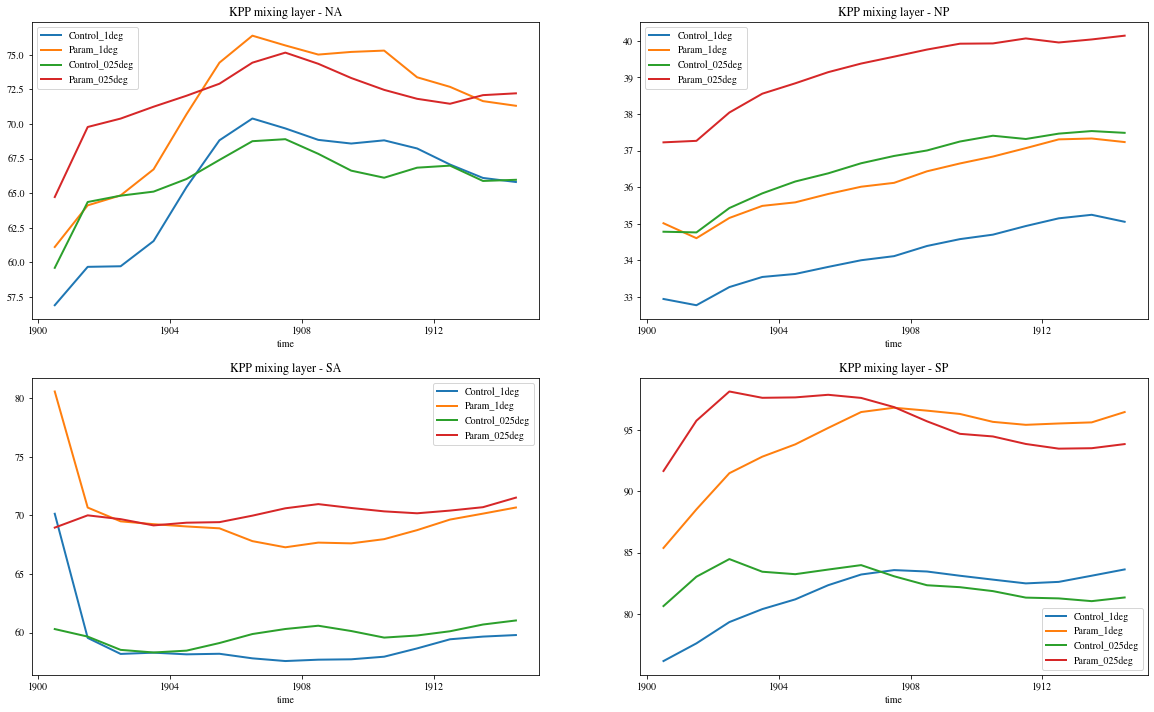

In [5]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    hblt = cc.querying.getvar(expt = expt[i], session = j, variable = 'hblt', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hblt)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        hblt_basin = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hblt_basin = hblt_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hblt_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('KPP mixing layer - ' + basin[k])

## Animations

In [22]:
hblt_cont = cc.querying.getvar(expt = expt[0], session = session_1deg, variable = 'hblt', frequency = '1 monthly').sel(time = slice(start_time, end_time))
hblt_pram = cc.querying.getvar(expt = expt[1], session = session_1deg, variable = 'hblt', frequency = '1 monthly').sel(time = slice(start_time, end_time))

In [6]:
import netCDF4 as nc
import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [7]:
dir = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_control/output002/ocean'
file = os.path.join(dir,'ocean-2d-hblt-1-daily-mean-ym_1914_01.nc')

In [8]:
data = xr.open_dataset(file)
filename = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_control/output002/ocean/ocean-2d-hblt-1-daily-mean-ym_1914_01.nc'
particles = nc.Dataset(filename)
y = particles.variables['yt_ocean'][:]
x = particles.variables['xt_ocean'][:]
time1 = particles.variables['time'][:]

In [9]:
X,Y = np.meshgrid(x,y)

In [10]:
iter1 = 'ocean-2d-hblt-1-daily-mean-ym_1914_01.nc'
dir1 = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_control/output002/ocean'
dir2 = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_param_KPP/output002/ocean'

In [11]:
iter1 = 'ocean-2d-hblt-1-daily-mean-ym_1914_01.nc'
dir1 = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_control/output002/ocean'
dir2 = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_param_KPP/output002/ocean'

file1 = os.path.join(dir1,iter1)
file2 = os.path.join(dir2,iter1)

data1 = xr.open_dataset(file1)
data2 = xr.open_dataset(file2)

data1.hblt.time[364]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1914, 12, 31, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1914-12-31 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

In [ ]:
nframes = 364
startframe = 1
nt = 0

fig = plt.figure(figsize=(12,6))
rho = 1025

def updatefig(nt):
    plt.clf()
    currentframe = startframe + nt
    year = 1914
    day = nt
    
    iter1 = 'ocean-2d-hblt-1-daily-mean-ym_1914_01.nc'
    dir1 = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_control/output002/ocean'
    dir2 = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_param_KPP/output002/ocean'

    file1 = os.path.join(dir1,iter1)
    file2 = os.path.join(dir2,iter1)
    
    data1 = xr.open_dataset(file1)
    data2 = xr.open_dataset(file2)
    
    hblt_pram_day = data1.hblt.sel(time = slice(data1.hblt.time[nt].values,data1.hblt.time[nt+1].values)).mean('time')
    hblt_cont_day = data2.hblt.sel(time = slice(data1.hblt.time[nt].values,data1.hblt.time[nt+1].values)).mean('time')
    
    plt.title('Day %4d' % day)
    
    p1 = plt.contourf(X, Y, (hblt_pram_day - hblt_cont_day)/(hblt_cont_day), cmap = cm.cm.curl, levels = np.linspace(-1, 1, 21), extend = 'both')
    p1 = plt.colorbar(p1,orientation = 'vertical', shrink = 0.8)
    
    filestr = '/home/156/db6174/x77/1deg_test_runs/Parameterising_KPP_shear/Animations/KPP_param_comp/Figures/image%04d.png' % nt
    plt.savefig(filestr,dpi = 900)
    print(nt)        
    return p1
    
anim = animation.FuncAnimation(fig, updatefig, frames=nframes, interval = 1, blit=False)
metadata = dict(title='MOC_Yearly', artist='GFD ANU',comment='Animation made using matplotlib and ffmpeg')
ffwriter = animation.FFMpegWriter(fps=8, codec='libx264', bitrate=4000, extra_args=['-pix_fmt','yuv420p'], metadata=metadata)
anim.save('Animations/KPP_param_comp/hblt_diff.m4v', writer=ffwriter)

plt.show()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
